In [1]:
#Imports
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchmetrics import Accuracy
import torch.nn.functional as F
import torch.optim as optim
from time import sleep 
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
#Model
class CNN(nn.Module):
    def __init__(self,num_classes,in_channels=1):
        super(CNN, self).__init__()
        self.CNN1 = self.CNNBlock(1,10,3,1,'same')
        self.CNN2 = self.CNNBlock(10,30,3,1,'same')
        self.CNN3 = self.CNNBlock(30,50,3,1,'same')
        self.CNN4 = self.CNNBlock(50,100,3,1,'same')
        self.Linear = nn.Linear(100,10)

    def CNNBlock(self,in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size , stride, padding),
                             nn.BatchNorm2d(out_channels),
                             nn.LeakyReLU(0.1),
                             nn.MaxPool2d(kernel_size=2, stride=2))
        
    def forward(self,x):
        x = self.CNN1(x)
        x = self.CNN2(x)
        x = self.CNN3(x)
        x = self.CNN4(x)
        x = x.view(x.shape[0],-1)
        x = self.Linear(x)
        return x

In [3]:
def cross_entropy_loss(predictions, target):
    loss = nn.CrossEntropyLoss()
    return loss(predictions, target)

In [4]:
#Training
def train_fn_(train_loader, model, optimizer, epoch):
    model.train()
    mean_loss = []
    mean_accuracy = []
    with tqdm(train_loader, unit="batch",bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}') as loop:     #tqdm to show progress bar for each training epoch
            loop.set_description(f"Epoch {epoch}")
            for batch_idx, (image, label) in enumerate(loop):
                image, label= image.to(DEVICE), label.to(DEVICE)

                pred = model(image)
                loss = cross_entropy_loss(pred, label)
                mean_loss.append(loss.item())    
                optimizer.zero_grad()                 #all gradient should be zero in next epoch and should not carry previous gradients

                loss.backward()                       #calculates the gradient update for each layer
                nn.utils.clip_grad_norm_(model.parameters(), 4.0)
                optimizer.step()                      #update the weights  
                sleep(0.1)

                model.eval()
                accuracy = Accuracy(top_k=1).to(DEVICE)
                acc = accuracy(pred, label)
                model.train()
                mean_accuracy.append(acc.item())
 
            print(f"Train loss: {sum(mean_loss) / len(mean_loss)} | Train Accuracy: {sum(mean_accuracy) / len(mean_accuracy)}")  
    return sum(mean_loss) / len(mean_loss), sum(mean_accuracy) / len(mean_accuracy)

In [5]:
#Evaluate model
def eval_model(test_loader, model, optimizer, return_pred=False):
    model.eval()
    mean_loss = []
    mean_accuracy = []

    for batch_idx, (image, label) in enumerate(test_loader):
        image, label= image.to(DEVICE), label.to(DEVICE)

        pred = model(image)
        loss = cross_entropy_loss(pred, label)
        mean_loss.append(loss.item())    
        
        accuracy = Accuracy(top_k=1).to(DEVICE)
        acc = accuracy(pred, label)
        mean_accuracy.append(acc.item())
    
    if return_pred:
        return pred, label
    else:
        return sum(mean_loss) / len(mean_loss) , sum(mean_accuracy) / len(mean_accuracy)

In [6]:
def save_checkpoint(state, filename="my_checkpoint.pth"):
    print("=> Saving checkpoint")
    torch.save(state, filename) 

In [7]:
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [8]:
def predict(image):
    image = image.unsqueeze(0)
    pred = model(image)
    pred_class = torch.argmax(pred).item()
    return pred_class

In [9]:
#Load data

#transforms
transform = transforms.Compose([transforms.ToTensor(),
                              #transforms.Normalize((0.5,), (0.5,)),
                              ])

dir_path = "/home/spanidea-168/Documents/assignment/dataset"
train_data = datasets.MNIST(dir_path, download=True, train=True, transform=transform)
test_data = datasets.MNIST(dir_path, download=True, train=False, transform=transform)

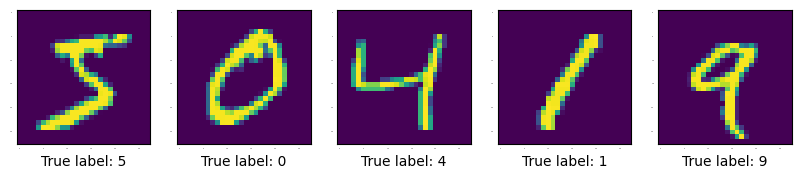

In [10]:
#Visualize dataset
plt.figure(figsize=(10, 30))

for i in range(5):
    plt.subplot(1, 5, i+1)
    img,label = train_data.__getitem__(i)
    plt.imshow(img[0].numpy())
    plt.xlabel(f"True label: {label}")
    plt.tick_params(which = 'both', size = 0, labelsize = 0)

In [11]:
#Hyperparameters
BATCH_SIZE = 200
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 1e-4
EPOCHS = 10
LOAD_MODEL = False
LOAD_MODEL_FILE = "/home/spanidea-168/Documents/assignment/model_cnn.pth" 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
#Start training

#Load model
model = CNN(num_classes=10).to(DEVICE)

optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

#Load data
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.__len__(), shuffle=True)

train_loss_epochs = []
train_acc_epochs = []
test_loss_epochs = []
test_acc_epochs = []

for epoch in range(EPOCHS):

    train_loss, train_acc = train_fn_(train_loader, model, optimizer, epoch)
    test_loss, test_acc = eval_model(test_loader, model, optimizer)
    print(f"Test Loss: {test_loss} | Test Accuracy: {test_acc}")
    
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)
    test_loss_epochs.append(test_loss)
    test_acc_epochs.append(test_acc)
          
checkpoint = {
            "state_dict": model.state_dict(), 
            "optimizer": optimizer.state_dict(), 
             } 
             
save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)   

Epoch 0: 100%|██████████| 300/300 [00:52<00:00,  5.72batch/s]                                                                                                            


Train loss: 1.560732523004214 | Train Accuracy: 0.6116499984264374
Test Loss: 0.9545661211013794 | Test Accuracy: 0.8564000129699707


Epoch 1: 100%|██████████| 300/300 [00:51<00:00,  5.79batch/s]                                                                                                            


Train loss: 0.7111284999052684 | Train Accuracy: 0.8893833315372467
Test Loss: 0.5057101845741272 | Test Accuracy: 0.9193999767303467


Epoch 2: 100%|██████████| 300/300 [00:52<00:00,  5.76batch/s]                                                                                                            


Train loss: 0.4285642084479332 | Train Accuracy: 0.9273000021775564
Test Loss: 0.33720147609710693 | Test Accuracy: 0.9416999816894531


Epoch 3: 100%|██████████| 300/300 [00:51<00:00,  5.78batch/s]                                                                                                            


Train loss: 0.3076314289867878 | Train Accuracy: 0.9435333291689555
Test Loss: 0.25395268201828003 | Test Accuracy: 0.9509000182151794


Epoch 4: 100%|██████████| 300/300 [00:51<00:00,  5.80batch/s]                                                                                                            


Train loss: 0.24063472305734954 | Train Accuracy: 0.9536333282788595
Test Loss: 0.20422518253326416 | Test Accuracy: 0.9588000178337097


Epoch 5: 100%|██████████| 300/300 [00:51<00:00,  5.82batch/s]                                                                                                            


Train loss: 0.1973690941433112 | Train Accuracy: 0.9610499980052313
Test Loss: 0.17027078568935394 | Test Accuracy: 0.963699996471405


Epoch 6: 100%|██████████| 300/300 [00:52<00:00,  5.72batch/s]                                                                                                            


Train loss: 0.16729401459296545 | Train Accuracy: 0.9658166704575221
Test Loss: 0.14578062295913696 | Test Accuracy: 0.9690999984741211


Epoch 7: 100%|██████████| 300/300 [00:51<00:00,  5.80batch/s]                                                                                                            


Train loss: 0.14518696437279383 | Train Accuracy: 0.9696166710058848
Test Loss: 0.12765532732009888 | Test Accuracy: 0.9728999733924866


Epoch 8: 100%|██████████| 300/300 [00:50<00:00,  5.98batch/s]                                                                                                            


Train loss: 0.12791435954471428 | Train Accuracy: 0.972883340716362
Test Loss: 0.11343488842248917 | Test Accuracy: 0.975600004196167


Epoch 9: 100%|██████████| 300/300 [00:49<00:00,  6.02batch/s]                                                                                                            


Train loss: 0.11415038835257292 | Train Accuracy: 0.9757166775067647
Test Loss: 0.10226161777973175 | Test Accuracy: 0.9782000184059143
=> Saving checkpoint


Text(0.5, 1.0, 'Testing curves')

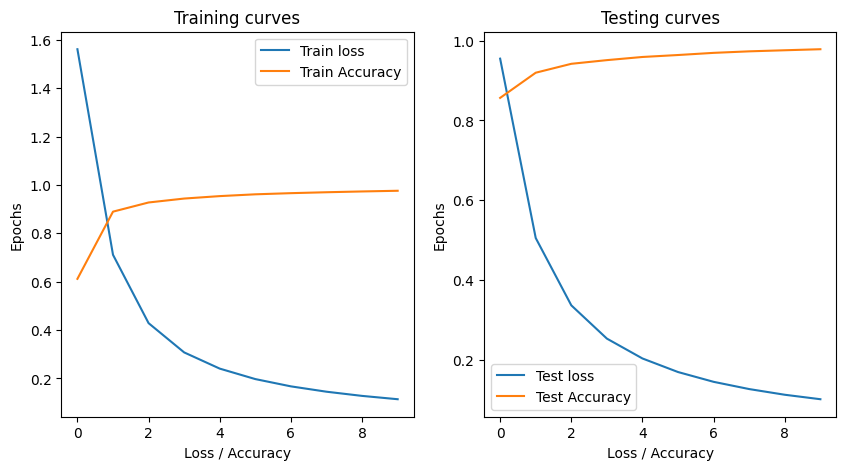

In [13]:
#Plotting training and testing curves
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(train_loss_epochs)
plt.plot(train_acc_epochs)
plt.legend(['Train loss','Train Accuracy'])
plt.xlabel('Loss / Accuracy')
plt.ylabel('Epochs')
plt.title('Training curves')

plt.subplot(1,2,2)
plt.plot(test_loss_epochs)
plt.plot(test_acc_epochs)
plt.legend(['Test loss','Test Accuracy'])
plt.xlabel('Loss / Accuracy')
plt.ylabel('Epochs')
plt.title('Testing curves')

In [14]:
#Evaluate model

test_loss, test_acc = eval_model(test_loader, model, optimizer)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

Test loss: 0.10226162523031235
Test accuracy: 0.9782000184059143


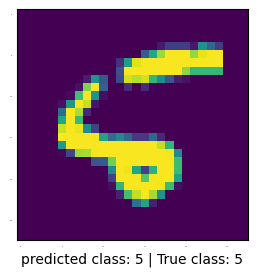

In [15]:
#Visualize a prediction results
img, label= test_data.__getitem__(8)
img = img.to(DEVICE)
pred_class = predict(img)
plt.figure(figsize=(3, 3))
plt.imshow(img[0].cpu())
plt.xlabel(f"predicted class: {pred_class} | True class: {label}")
plt.tick_params(which = 'both', size = 0, labelsize = 0)

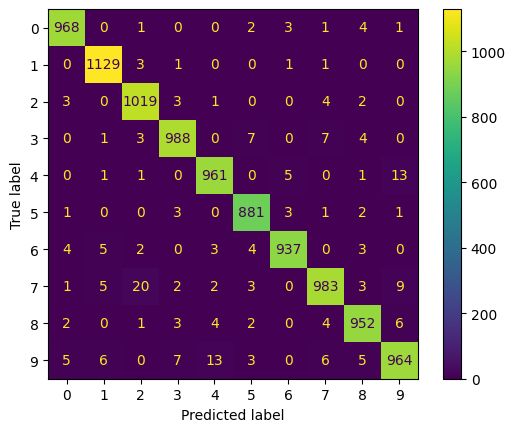

In [16]:
#Visualize Confusion matrix
y_pred, y_true = eval_model(test_loader, model, optimizer, return_pred=True)
y_pred, y_true = y_pred.detach().numpy(), y_true.detach().numpy()
y_pred = np.argmax(y_pred,1)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred)